In [21]:
### imports and function defs
import json
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import copy

strip_quotes = lambda s: s[1:-1] if len(s) > 1 and (s.startswith('"') and s.endswith('"') or s.startswith("'") and s.endswith("'")) else s

def get_sorted_layer_mult_combinations(data):
    """
    This function extracts and sorts the various layers and multipliers in the output file, which is assumed to be a num_sentence-sized array
    of dictionaries, which have keys "sentence", whose values are the prompts, "answer_neut", which is the unsteered model's output, and "steered",
    which is itself a dictionary, keyed by a string that combines layer and multiplier, whose values are dictionaries of steering type-output combinations
    """
    if not data:
        return []
    
    # Extract keys from the first item's 'steered' dictionary
    keys = list(data[0]['steered'].keys())

    # Map each layer to its order of appearance
    layer_order = {}
    order = 0  # To track the order of appearance

    # Parse keys into tuples (order, layer, mult)
    parsed_keys = []
    for key in keys:
        layer_part = key.split('_')[0][5:]
        mult_part = float(key.split('_')[1][4:])
        
        if layer_part not in layer_order:
            layer_order[layer_part] = order
            order += 1

        parsed_keys.append((layer_order[layer_part], layer_part, mult_part))

    # Sort by appearance order stored in layer_order, then by mult
    parsed_keys.sort(key=lambda x: (x[0], x[2]))  # x[0] is order, x[2] is mult

    # Return keys in the original format but sorted
#    sorted_keys = [f"layer{layer}_mult{str(mult).replace('.0', '')}" for _, layer, mult in parsed_keys]
    sorted_keys = [f"layer{layer}_mult{str(mult).rstrip('0').rstrip('.')}" for _, layer, mult in parsed_keys]### if int(layer)>=10]
    return sorted_keys
    
    
def plot_effectiveness(ax, df, n, title):
    proportions_df = df / n
    ci_95 = 1.96 * (proportions_df * (1 - proportions_df) / n)**0.5

    df = proportions_df
    lower_bound = (proportions_df - ci_95)
    upper_bound = (proportions_df + ci_95)
    for mult in df.columns:
        color = 'black' if mult == 0 else None  # Let Matplotlib choose the color for the other lines
        label = 'Original' if mult == 0 and title=="" else "Zeroed Out" if title=="" else f'{mult}' 
        print(df[mult])
        line, = ax.plot(df.index, df[mult], marker='o', linestyle='', label=label, color=color)
       
        ax.errorbar(df.index, df[mult],
                    yerr=[df[mult] - lower_bound[mult], upper_bound[mult] - df[mult]],
                    fmt='none', ecolor=line.get_color(), capsize=5, alpha=1.0)
    
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title(title)
    ax.set_xlabel('Layer')
    #ax.set_ylabel("Effectiveness")
    legend_title = 'Multiplier' if title!="" else ''
    ax.legend(title=legend_title)
    ax.grid(True)

strip_quotes = lambda s: s[1:-1] if len(s) > 1 and (s.startswith('"') and s.endswith('"') or s.startswith("'") and s.endswith("'")) else s


    0.0  0.0
16  1.8  1.8


ValueError: too many values to unpack (expected 1)

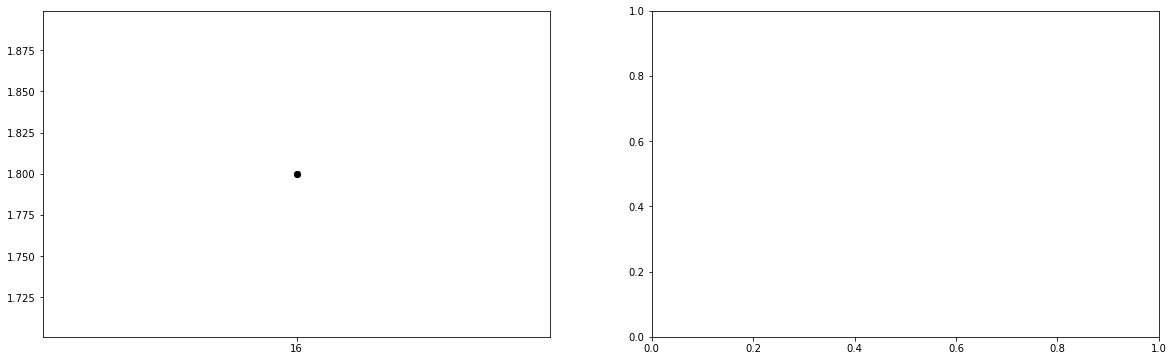

In [24]:
### Assess steering effectiveness
### Count up trues/falses/(A)s/(B)s by layer and mult
### Compute Accuracy%, CIs, and plot

model_name = "llama3_8bchat"
outputdir="/steering_results"
file = f"steering_results/steering_self-rec.json"

with open(file, 'r') as infile:
    resps = json.load(infile)

layer_mult_combinations = get_sorted_layer_mult_combinations(resps)

#get unique layers and mults from the keys
layers = list({key.split('_')[0][5:]: None for key in layer_mult_combinations}.keys())
mults = list(sorted(set(float(key.split('_')[1][4:]) for key in layer_mult_combinations)))

#set up dfs to hold results
pos_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
control_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=mults)
neg_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
pos_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
control_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=mults)
neg_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
pos_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
control_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=mults)
neg_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)

zeroedout_pos_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_neg_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_pos_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_neg_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_pos_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_neg_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)

def task_pos(resp, val, flip=False):
    #return (resp.lower().strip() == "a" if val == "pos" else resp.lower().strip() == "b") if not flip else (resp.lower().strip() == "b" if val == "pos" else resp.lower().strip() == "a")
###    if "individual_steering_selfrecnew3_projectoutnuisance_meandiff" in file: return (resp.lower().strip() == "1" if val == "pos" else resp.lower().strip() == "2") if not flip else (resp.lower().strip() == "2" if val == "pos" else resp.lower().strip() == "1")
    if "steering_results/steering_self-rec.json" in file or "individual_steering_selfrecnew3_dummyaffirmation" in file: return (resp.lower().strip() == "a" if val == "pos" else resp.lower().strip() == "b") if not flip else (resp.lower().strip() == "b" if val == "pos" else resp.lower().strip() == "a")
    if "paired" in file: return (resp.strip() == "1" if val == "pos" else resp.strip() == "2") if not flip else (resp.strip() == "2" if val == "pos" else resp.strip() == "1")
    if "dummyab" in file: return (resp.lower() == "a" if val == "pos" else resp.lower() == "b")
    if "dummyyesno" in file: return resp.lower() == "yes" if val == "pos" else resp.lower() == "no"
#     return "yes" in resp.lower() if val == "pos" else "no" in resp.lower()
#     return resp.lower() == "me" if val == "pos" else resp.lower() in ["another", "other"]
#     return resp.lower() == "b" if val == "pos" else resp.lower() == "a"
#     return resp.lower() in ["another", "other"] if val =="pos" else resp.lower() == "me"
#     return resp.lower() == "no" if val == "pos" else resp.lower() == "yes"
#     return "no" in resp.lower() if val == "pos" else "yes" in resp.lower()

for layermult in layer_mult_combinations:
    layer = layermult.split('_')[0][5:]
    mult = float(layermult.split('_')[1][4:])
    #print(f"Layer {layer}, Mult {mult}")

    sentctr=0
    truectr, falsectr = 0, 0
    for i, entry in enumerate(resps):
        #true_label = 1 if entry['sentence']['model'] == model_name else -1
        true_label = 1 if i % 2 == 0 else -1
        match = re.search(r"\?\nA\) ([^\n]+)\nB\) ", entry['sentence'])
###        match = re.search(r"\?\n1\) ([^\n]+)\n2\) ", entry['sentence'])
        if "steering_results/steering_self-rec.json" in file: flip = "some" in match.group(1).lower() or "another" in match.group(1).lower()
        if "paired" in file: flip = i % 2
        if "dummyaffirmation" in file: flip = "A) No" in entry['sentence']
###        if flip: continue
        if true_label == 1:
            truectr += 1
            if task_pos(entry['steered'][layermult]['answer_pos'],"pos", flip): 
                pos_effectiveness_df.loc[layer, mult] += 1
                pos_effectiveness_truths_df.loc[layer, mult] += 1
            if task_pos(entry['steered'][layermult]['answer_neg'], "neg", flip): 
                neg_effectiveness_df.loc[layer, mult] += 1
                neg_effectiveness_truths_df.loc[layer, mult] += 1
            if task_pos(entry['answer_neut'], "pos", flip): 
                control_effectiveness_df.loc[layer, mult] += 1
                control_effectiveness_truths_df.loc[layer, mult] += 1
                pos_effectiveness_df.loc[layer, 0] += 1/len(mults) #control (0 mult)
                pos_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
            elif task_pos(entry['answer_neut'], "neg", flip): 
                neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                neg_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
            if task_pos(entry['steered'][layermult]['answer_zeroedout'], "pos", flip): 
                zeroedout_pos_effectiveness_df.loc[layer, mult] += 1
                zeroedout_pos_effectiveness_truths_df.loc[layer, mult] += 1
        else:
            falsectr += 1
            if task_pos(entry['steered'][layermult]['answer_pos'], "pos", flip): 
                pos_effectiveness_df.loc[layer, mult] += 1
                pos_effectiveness_lies_df.loc[layer, mult] += 1
            if task_pos(entry['steered'][layermult]['answer_neg'], "neg", flip): 
                neg_effectiveness_df.loc[layer, mult] += 1
                neg_effectiveness_lies_df.loc[layer, mult] += 1
            if task_pos(entry['answer_neut'], "neg", flip): 
                control_effectiveness_df.loc[layer, mult] += 1
                control_effectiveness_lies_df.loc[layer, mult] += 1
                neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                neg_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
            elif task_pos(entry['answer_neut'], "pos", flip): 
                pos_effectiveness_df.loc[layer, 0] += 1/len(mults)
                pos_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
            if task_pos(entry['steered'][layermult]['answer_zeroedout'], "neg", flip): 
                zeroedout_neg_effectiveness_df.loc[layer, mult] += 1
                zeroedout_neg_effectiveness_lies_df.loc[layer, mult] += 1
            elif task_pos(entry['steered'][layermult]['answer_zeroedout'], "pos", flip): 
                zeroedout_pos_effectiveness_df.loc[layer, mult] += 1
        sentctr += 1

#fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
#plot_effectiveness(axs[0], pos_effectiveness_df, sentctr, f"+Vector Effectiveness; {model_name.capitalize()}")
#plot_effectiveness(axs[1], neg_effectiveness_df, sentctr, f"-Vector Effectiveness; {model_name.capitalize()}")
#plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
plot_effectiveness(axs[0], pos_effectiveness_truths_df, truectr, f"+Vector: Authorship Claims on Self-Written Texts")
plot_effectiveness(axs[1], pos_effectiveness_lies_df, falsectr, f"+Vector Authorship Claims on Other-Written Texts")
#plot_effectiveness(axs[0], pos_effectiveness_truths_df, truectr, f"+Vector: Affirmative Answers When Names Are Present")
#plot_effectiveness(axs[1], pos_effectiveness_lies_df, falsectr, f"+Vector Affirmative Answers When Names Are Absent")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
plot_effectiveness(axs[0], neg_effectiveness_truths_df, truectr, f"-Vector Authorship Denials on Self-Written Texts")
plot_effectiveness(axs[1], neg_effectiveness_lies_df, falsectr, f"-Vector Authorship Denials on Other-Written Texts")
#plot_effectiveness(axs[0], neg_effectiveness_truths_df, truectr, f"-Vector Negative Answers When Names Are Present")
#plot_effectiveness(axs[1], neg_effectiveness_lies_df, falsectr, f"-Vector Negative Answers When Names Are Absent")
plt.show()

#fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
#plot_effectiveness(axs[0], zeroedout_pos_effectiveness_df.iloc[:, :2], sentctr, f"Zeroedout Vector: Authorship Claims on All Texts")
#plot_effectiveness(axs[1], zeroedout_pos_effectiveness_truths_df.iloc[:, :2], truectr, f"Zeroedout Vector Effectiveness on Self-Written")
#plot_effectiveness(axs[2], zeroedout_neg_effectiveness_lies_df.iloc[:, :2], falsectr, f"Zeroedout Vector Effectiveness on Other-Written")
#plt.show()


In [40]:
file = f"steering_results/steering_self-rec.json"

with open(file, 'r') as infile:
    resps = json.load(infile)
pos_count=0
neg_count=0

dic_pos={}
dic_neg={}
for i in resps:
    import re
    normalized = re.sub(r'\s+', ' ', i['sentence']).strip()
    #print("A) Someone else B) Me" in normalized) 
    
    if ("A) Me B) Someone else" in normalized) or ("A) I wrote it B) Another author wrote it" in normalized) or ("A) The author is myself B) The author is somebody else" in normalized) or ("A) It was written by me B) It was written by another" in normalized):
        
        if i['steered']['layer16_mult6']['answer_pos'].lower()=='a':
            pos_count+=1
        if i['steered']['layer16_mult6']['answer_neg'].lower()=='b':
            neg_count+=1
    if "A) Someone else B) Me" in normalized or  "A) Another author wrote it B) I wrote it" in normalized or "A) The author is somebody else B) The author is myself" in normalized or "A) It was written by another B) It was written by me" in normalized:
        
        if i['steered']['layer16_mult6']['answer_pos'].lower()=='b':
           pos_count+=1
        if i['steered']['layer16_mult6']['answer_neg'].lower()=='a':
            neg_count+=1
dic_pos[(16,6)]=pos_count/len(resps)
dic_neg[(16,6)]=neg_count/len(resps)
labels = list(data.keys())
values = list(data.values())
print(pos_count/len(resps))
print(neg_count/len(resps))
            
            

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
1.0
0.955


ValueError: too many values to unpack (expected 1)

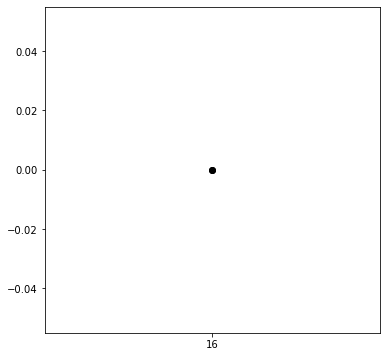

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6)) 
plot_effectiveness(axs, zeroedout_pos_effectiveness_df.iloc[:, :2], sentctr,"")
#save the plot
plt.savefig(f"./figs_new/zeroedout_chart_qa.png")

In [527]:
n=sentctr*2
df = (pos_effectiveness_truths_df+pos_effectiveness_lies_df+neg_effectiveness_truths_df+neg_effectiveness_lies_df)/n
ci_95 = 1.96 * (df * (1 - df) / n)**0.5

lower_bound = (df - ci_95)
upper_bound = (df + ci_95)
df_qa=copy.deepcopy(df)
df_qa

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,10.0,14.0
3,0.5,0.5325,0.3875,0.0000,0.0350,0.0125,0.0075,0.0000,0.0000
4,0.5,0.2325,0.2075,0.3700,0.0075,0.0050,0.0550,0.0125,0.0000
5,0.5,0.2325,0.5450,0.4700,0.0000,0.0025,0.0050,0.0025,0.0000
6,0.5,0.5050,0.5000,0.4575,0.1325,0.0450,0.0000,0.0050,0.0000
7,0.5,0.2575,0.3300,0.5625,0.4475,0.2325,0.2200,0.0025,0.0000
8,0.5,0.4625,0.5725,0.6050,0.3275,0.2200,0.0550,0.0025,0.1925
9,0.5,0.6750,0.7225,0.7625,0.7575,0.6175,0.5000,0.1500,0.1225
10,0.5,0.6375,0.6875,0.6000,0.4375,0.4500,0.1525,0.0000,0.0000
11,0.5,0.5950,0.6100,0.6550,0.6400,0.3125,0.2825,0.2300,0.0000
12,0.5,0.7775,0.8550,0.8675,0.9300,0.9450,0.8425,0.2625,0.0050


In [525]:
n=sentctr*2
df = (pos_effectiveness_truths_df+pos_effectiveness_lies_df+neg_effectiveness_truths_df+neg_effectiveness_lies_df)/n
ci_95 = 1.96 * (df * (1 - df) / n)**0.5

lower_bound = (df - ci_95)
upper_bound = (df + ci_95)
df_mixed1=copy.deepcopy(df)
df_mixed1

,0.0,3.0,4.0,5.0,6.0,10.0,14.0
10,0.5,0.6275,0.4900,0.4125,0.2400,0.0000,0.0000
11,0.5,0.5825,0.6025,0.3075,0.2250,0.2000,0.0000
12,0.5,0.8825,0.8475,0.8000,0.7050,0.1950,0.0475
13,0.5,0.7300,0.7525,0.7250,0.6525,0.2800,0.2725
14,0.5,0.9750,0.9900,0.9825,0.9750,0.4225,0.0000
15,0.5,0.9925,1.0000,1.0000,0.9950,0.7425,0.0875
16,0.5,0.9975,1.0000,1.0000,0.9975,0.8800,0.4025
17,0.5,0.7675,0.7875,0.7950,0.7775,0.6900,0.6975
18,0.5,0.5700,0.5850,0.5700,0.5575,0.4875,0.5950
19,0.5,0.5600,0.6075,0.6125,0.6200,0.6475,0.7175


In [522]:
n=sentctr*2
df = (pos_effectiveness_truths_df+pos_effectiveness_lies_df+neg_effectiveness_truths_df+neg_effectiveness_lies_df)/n
ci_95 = 1.96 * (df * (1 - df) / n)**0.5

lower_bound = (df - ci_95)
upper_bound = (df + ci_95)
df_mixed2=copy.deepcopy(df)
df_mixed2

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,10.0,14.0
3,0.5,0.4825,0.4625,0.4625,0.5450,0.5325,0.5225,0.5400,0.2650
4,0.5,0.4750,0.4350,0.3925,0.4000,0.4700,0.4675,0.6075,0.2275
5,0.5,0.4775,0.4450,0.3775,0.3650,0.3950,0.4200,0.4400,0.2975
6,0.5,0.4375,0.4075,0.3800,0.3825,0.4225,0.4825,0.4975,0.2850
7,0.5,0.4475,0.4250,0.4125,0.4350,0.4875,0.4450,0.4950,0.2900
8,0.5,0.4625,0.4700,0.4500,0.4650,0.5350,0.5700,0.5025,0.4725
9,0.5,0.5300,0.5225,0.5325,0.5300,0.5100,0.5225,0.4900,0.5125
10,0.5,0.4700,0.4425,0.4350,0.4350,0.4275,0.4550,0.4625,0.5000
11,0.5,0.4525,0.4250,0.4375,0.4675,0.4550,0.4825,0.4750,0.5350
12,0.5,0.5200,0.5300,0.5175,0.5175,0.5300,0.5400,0.6125,0.5125


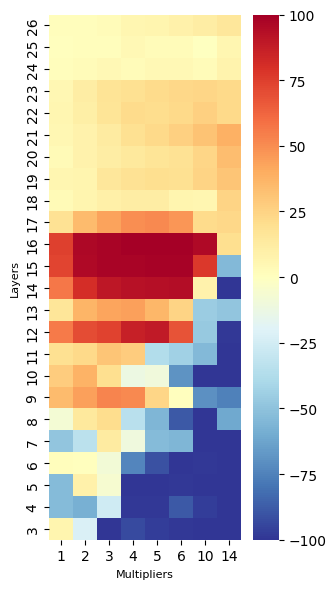

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def compute_percentage_difference(row):
    first_value = row.iloc[0]
    differences = row.iloc[1:] - first_value
    
    # Normalize differences to percentage of possible range
    max_possible_difference = 1 - first_value if differences.max() > 0 else first_value
    return differences / max_possible_difference * 100


n=sentctr*2
df = (pos_effectiveness_truths_df+pos_effectiveness_lies_df+neg_effectiveness_truths_df+neg_effectiveness_lies_df)/n

# Create a new DataFrame with computed values, excluding the first column
df_computed = df.apply(compute_percentage_difference, axis=1)
df_computed = df_computed.iloc[::-1]
plt.figure(figsize=(3.4, 6))
sns.heatmap(df_computed, annot=False, cmap="RdYlBu_r", fmt=".0f", center=0)

#plt.title("Aggregated Steering Effectiveness", fontsize=16)
plt.xlabel("Multipliers", fontsize=8)
plt.ylabel("Layers", fontsize=8)

current_xticks = plt.gca().get_xticks()
current_xlabels = [float(label.get_text()) for label in plt.gca().get_xticklabels()]
new_xlabels = [int(label) for label in current_xlabels]
plt.xticks(current_xticks, new_xlabels, rotation=0, ha='center')

plt.tight_layout()
#plt.savefig(f"./figs_new/steering_heatmap_qa.png")
plt.show()


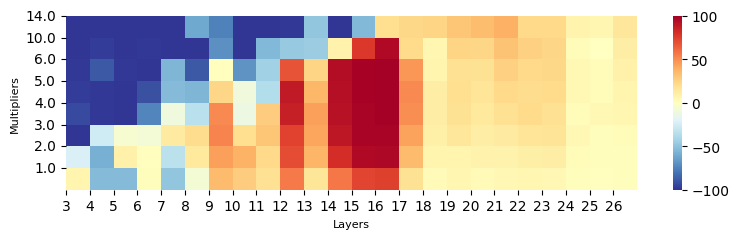

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def compute_percentage_difference(row):
    first_value = row.iloc[0]
    differences = row.iloc[1:] - first_value
    
    # Normalize differences to percentage of possible range
    max_possible_difference = 1 - first_value if differences.max() > 0 else first_value
    return differences / max_possible_difference * 100


n=sentctr*2
df = (pos_effectiveness_truths_df+pos_effectiveness_lies_df+neg_effectiveness_truths_df+neg_effectiveness_lies_df)/n

# Create a new DataFrame with computed values, excluding the first column
df_computed = df.apply(compute_percentage_difference, axis=1)
df_computed = df_computed.iloc[::-1]

# Transpose and reverse both axes to get correct ordering
df_rotated = df_computed.T.iloc[::-1, ::-1]

# Create figure with flatter aspect ratio
plt.figure(figsize=(8, 2.5))

# Create heatmap with transposed data
sns.heatmap(df_rotated, 
            annot=False, 
            cmap="RdYlBu_r", 
            fmt=".0f", 
            center=0)

#plt.title("Aggregated Steering Effectiveness", fontsize=16)
plt.ylabel("Multipliers", fontsize=8)
plt.xlabel("Layers", fontsize=8)

# Get original row labels (layers) and reverse them to match the reversed data
original_layers = df_computed.index.tolist()[::-1]

# Set x-axis ticks using original layer values
plt.xticks(np.arange(len(original_layers)), 
          original_layers,
          rotation=0, 
          ha='center')

# Get original column labels (multipliers) and reverse them
original_multipliers = df_computed.columns.tolist()[::-1]

# Set y-axis ticks using multiplier values
plt.yticks(np.arange(len(original_multipliers)), 
          original_multipliers,
          rotation=0, 
          ha='right', 
          va='center')

plt.tight_layout()
plt.savefig(f"./figs_new/steering_heatmap_qa_rot.png")
plt.show()

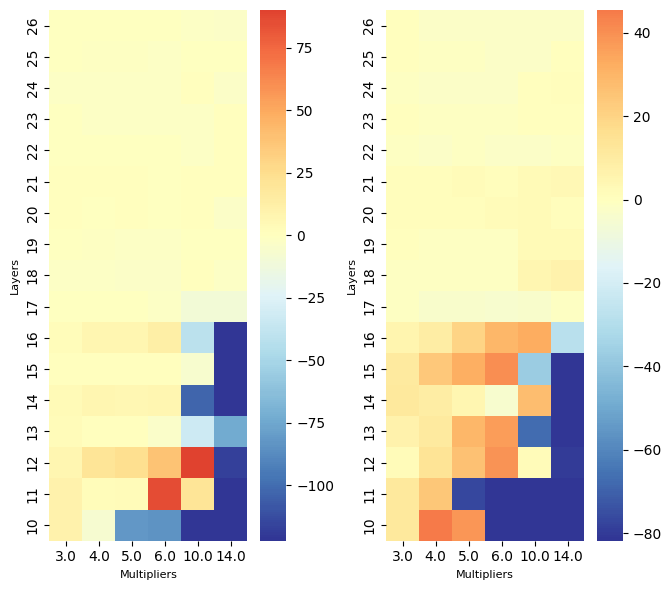

In [851]:
def compute_percentage_difference(row):
    first_value = row.iloc[0]
    differences = row.iloc[1:] - first_value
    
    # Normalize differences to percentage of possible range
    max_possible_difference = 1 - first_value if differences.max() > 0 else first_value
    return differences / max_possible_difference * 100

n = sentctr

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.8, 6))

# Positive steering heatmap
df_pos = (pos_effectiveness_truths_df + pos_effectiveness_lies_df) / n
df_pos_computed = df_pos.apply(compute_percentage_difference, axis=1)
df_pos_computed = df_pos_computed.iloc[::-1]
sns.heatmap(df_pos_computed, annot=False, cmap="RdYlBu_r", fmt=".0f", center=0, ax=ax1)
ax1.set_xlabel("Multipliers", fontsize=8)
ax1.set_ylabel("Layers", fontsize=8)


# Negative steering heatmap
df_neg = (neg_effectiveness_truths_df + neg_effectiveness_lies_df) / n
df_neg_computed = df_neg.apply(compute_percentage_difference, axis=1)
df_neg_computed = df_neg_computed.iloc[::-1]
sns.heatmap(df_neg_computed, annot=False, cmap="RdYlBu_r", fmt=".0f", center=0, ax=ax2)
ax2.set_xlabel("Multipliers", fontsize=8)
ax2.set_ylabel("Layers", fontsize=8)

plt.tight_layout()
plt.savefig(f"./figs_new/dummyaffirmation_steering_heatmap.png")
plt.show()

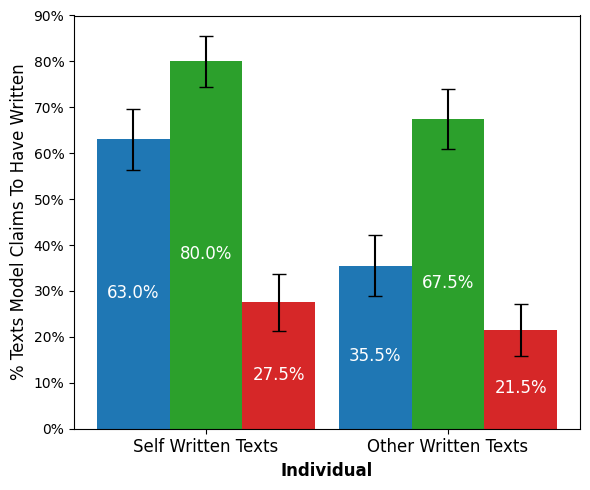

In [882]:
import matplotlib.pyplot as plt
import numpy as np

n = sentctr / 2 

data = [(df.iloc[0][df.columns[0]], df.iloc[0][0.25]) for df in [
    pos_effectiveness_truths_df,
    neg_effectiveness_truths_df,
    pos_effectiveness_lies_df,
    neg_effectiveness_lies_df
]]

# Calculate proportions
y_orig = [data[0][0]/n, data[2][0]/n]  # Original rates for self and other
y_steered_pos = [data[0][1]/n, data[2][1]/n]  # Positive steering for self and other
y_steered_neg = [1-data[1][1]/n, 1-data[3][1]/n]  # Negative steering for self and other

# Error calculation for 95% confidence intervals
error_orig = [1.96 * np.sqrt((p * (1-p)) / n) for p in y_orig]
error_steered_pos = [1.96 * np.sqrt((p * (1-p)) / n) for p in y_steered_pos]
error_steered_neg = [1.96 * np.sqrt((p * (1-p)) / n) for p in y_steered_neg]

plt.figure(figsize=(6, 5))
x = np.array([0, 0.5])  # Reduced space between sets of bars

bar_width = 0.15
x_orig = x - bar_width  # For unsteered
x_pos = x              # For positive steering
x_neg = x + bar_width  # For negative steering

# Color choices
colors = ['#1f77b4', '#2ca02c', '#d62728']

# Plotting bars
bars_orig = plt.bar(x_orig, y_orig, width=bar_width, color=colors[0], label='Unsteered', yerr=error_orig, capsize=5)
bars_pos = plt.bar(x_pos, y_steered_pos, width=bar_width, color=colors[1], label='Positive Steering', yerr=error_steered_pos, capsize=5)
bars_neg = plt.bar(x_neg, y_steered_neg, width=bar_width, color=colors[2], label='Negative Steering', yerr=error_steered_neg, capsize=5)

# Adding text inside bars (now as percentages)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, max(0.02, height - height/2), f'{height:.1%}', ha='center', va='top', color='white', fontsize=12)

add_labels(bars_orig)
add_labels(bars_pos)
add_labels(bars_neg)

plt.xlabel('Individual', fontsize=12, fontweight='bold')
plt.ylabel('% Texts Model Claims To Have Written', fontsize=12)
#plt.title('Text Coloring Effects by Steering and Text Type', fontsize=16)
plt.xticks(x, ['Self Written Texts', 'Other Written Texts'], fontsize=12)
plt.ylim(0, max(max(y_orig + error_orig), max(y_steered_pos + error_steered_pos), max(y_steered_neg + error_steered_neg)) + 0.1)  # Adjust y-axis limit

# Set y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#plt.legend()
plt.tight_layout()
plt.savefig(f"./figs_new/coloring_indiv_qa.png")
plt.show()


In [678]:
import numpy as np
from scipy import stats

def analyze_steering_effect(results, direction, steering_condition):
    original_probs = []
    steered_probs = []

    for i, entry in enumerate(results):
        if "bothdir" in file and (i % 2) and ("zeroedout" in direction): continue #zeroing out both texts, so odd and even inputs are the same
        # Extract the original probability
        base = "prob_targ_neut" if "targ" in direction else "prob_neut"
        prob_neut = entry.get(base)
        if prob_neut is None:
            print("missing prob_neut")
            continue  # Skip if original probability is missing
        original_probs.append(prob_neut)

        # Extract the zeroed-out probability
        steered = entry.get("steered", {})
        steered_entry = steered.get(steering_condition, {})
        steered_prob = steered_entry.get(direction)
        if steered_prob is None:
            print("missing steered_prob")
            continue  # Skip if steered probability is missing
        steered_probs.append(steered_prob)

    # Convert lists to numpy arrays
    original_probs = np.array(original_probs)
    steered_probs = np.array(steered_probs)

    # Ensure arrays are of the same length
    min_length = min(len(original_probs), len(steered_probs))
    original_probs = original_probs[:min_length]
    steered_probs = steered_probs[:min_length]

    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(original_probs, steered_probs)

    # Calculate mean difference
    mean_diff = np.mean(original_probs - steered_probs)

    # Prepare the results
    test_results = {
        "t_statistic": t_stat,
        "p_value": p_value,
        "mean_difference": mean_diff,
        "original_probs_mean": np.mean(original_probs),
        "steered_probs_mean": np.mean(steered_probs),
        "num_samples": len(original_probs)
    }

    return test_results, original_probs, steered_probs


file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad_colortext_bothdir.json"
file = f"{outputdir}individual_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_qa_colortext3.json"
#file = f"{outputdir}individual_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_mixed2_colortext.json"
with open(file, 'r') as infile:
    resps = json.load(infile)
test_results, original_probs, steered_probs = analyze_steering_effect(resps, "prob_zeroedout", steering_condition="layer0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31_mult0.05")

print("Statistical Test Results:")
print(f"Number of samples: {test_results['num_samples']}")
print(f"Mean of original probabilities: {test_results['original_probs_mean']}")
print(f"Mean of steered probabilities: {test_results['steered_probs_mean']}")
print(f"Mean difference: {test_results['mean_difference']}")
print(f"T-statistic: {test_results['t_statistic']}")
print(f"P-value: {test_results['p_value']}")

# Bootstrap resampling
n_bootstrap = 10000
bootstrap_deltas = np.zeros(n_bootstrap)

n = len(original_probs)
#np.random.seed(42)

for i in range(n_bootstrap):
    sample_orig = np.random.choice(original_probs, size=n, replace=True)
    sample_steered = np.random.choice(steered_probs, size=n, replace=True)
    bootstrap_deltas[i] = np.mean(sample_orig) - np.mean(sample_steered)

alpha = 0.01
lower = np.percentile(bootstrap_deltas, alpha/2*100)
upper = np.percentile(bootstrap_deltas, (1 - alpha/2)*100)
print(f"99% confidence interval: [{lower}, {upper}]")


Statistical Test Results:
Number of samples: 200
Mean of original probabilities: 0.46967457497055876
Mean of steered probabilities: 0.44455045467853777
Mean difference: 0.025124120292020963
T-statistic: 2.8596209300074924
P-value: 0.0046936792251383195
99% confidence interval: [-0.061125587202352456, 0.10638969522312448]


(array([ 7.,  0.,  1.,  1.,  2.,  1.,  0.,  3.,  1.,  1.,  2.,  1.,  3.,
         4.,  2.,  3.,  0.,  2.,  2.,  3.,  0.,  2.,  3.,  1.,  2.,  3.,
         1.,  4.,  2.,  1.,  3.,  0.,  3.,  2.,  3.,  3.,  1.,  5.,  2.,
         3.,  4.,  4.,  7.,  4.,  6.,  4.,  8.,  5.,  9., 36.]),
 array([0.00698706, 0.02684676, 0.04670645, 0.06656615, 0.08642584,
        0.10628554, 0.12614524, 0.14600493, 0.16586463, 0.18572432,
        0.20558402, 0.22544372, 0.24530341, 0.26516311, 0.28502281,
        0.3048825 , 0.3247422 , 0.34460189, 0.36446159, 0.38432129,
        0.40418098, 0.42404068, 0.44390037, 0.46376007, 0.48361977,
        0.50347946, 0.52333916, 0.54319886, 0.56305855, 0.58291825,
        0.60277794, 0.62263764, 0.64249734, 0.66235703, 0.68221673,
        0.70207642, 0.72193612, 0.74179582, 0.76165551, 0.78151521,
        0.80137491, 0.8212346 , 0.8410943 , 0.86095399, 0.88081369,
        0.90067339, 0.92053308, 0.94039278, 0.96025247, 0.98011217,
        0.99997187]),
 <BarContainer

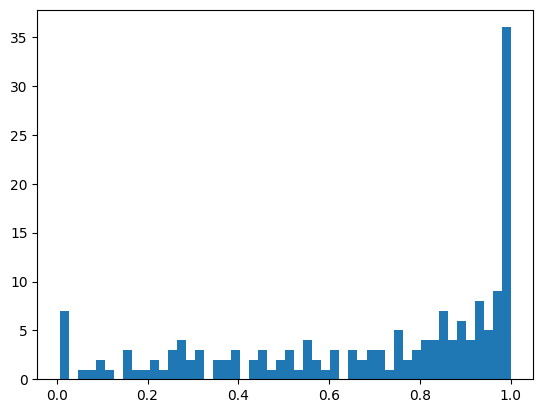

In [671]:
plt.hist(original_probs, bins=50)

In [6]:
file = f"{outputdir}individual_steering_output_test_meandiff.json"
#file = f"{outputdir}individual_steering_output_nnprobes_20before.json"
#file = f"{outputdir}individual_steering_output_test_dummytask_meandiff.json"
#file = f"{outputdir}individual_steering_output_nnprobes_dummytask_20before.json"
file = f"{outputdir}individual_steering_output_origtask_20before.json"
file = f"{outputdir}individual_steering_output_meandiff_offset23.json"
file = f"{outputdir}individual_steering_output_dummytask_meandiff_offset23.json"
#file = f"{outputdir}individual_steering_authortask_meandiff_offset23_coronly_onincor3.json"
#file = f"{outputdir}individual_steering_dummytask_ab_meandiff_offset23_coronly2.json"
file = f"{outputdir}individual_steering_dummytask_meandiff_offset23_coronly.json"
file = f"{outputdir}individual_steering_promptrev_ab_meandiff_offset23_coronly.json"
file = f"{outputdir}individual_steering_promptrev_ab2_meandiff_offset23_coronly.json"
file = f"{outputdir}individual_steering_promptrev2_meandiff_offset23_coronly.json"
file = f"{outputdir}individual_steering_promptrev2_meandiff_offset23_coronly.json"
file = f"{outputdir}individual_steering_promptrev2_projectout_meandiff_pc1diff_offset23_coronly.json"
file = f"{outputdir}individual_steering_authortask_projectout_meandiff_pc1diff_offset23_coronly.json"
file = f"{outputdir}individual_steering_promptrev2_projectout_pc12diff_pc12diff_offset23_coronly.json"
file = f"{outputdir}individual_steering_authortask_projectout_pc1diff_pc1diff_offset23_coronly_basemodel.json"
file = f"{outputdir}individual_steering_selfrecnew_meandiff_offset0_coronly_basemodel.json"
file = f"{outputdir}individual_steering_selfrecnew_nnprobe_offset0_coronly.json"
file = f"{outputdir}individual_steering_selfrecnew_nnprobe_offset0_coronly_basemodel.json"
file = f"{outputdir}individual_steering_selfrecnew_meandiff_offset0_coronly.json"
file = f"{outputdir}individual_steering_selfrecnew2_meandiff_offset0_coronly_basemodel.json"
file = f"{outputdir}individual_steering_dummyabtask_meandiff_offset0_coronly.json"
#file = f"{outputdir}individual_steering_selfrecnew2_meandiff_offset0_coronly.json"
file = f"{outputdir}individual_steering_dummyaffirmation_selfrecnew2_meandiff_projectout_offset1_coronly.json"
file = f"{outputdir}individual_steering_selfrecnew3_dummyab_meandiff_projectout_offset1_coronly.json"
file = f"{outputdir}individual_steering_selfrecnew3_meandiff_projectoutnuisance_offset1_coronly_basemodel.json"

layermult="layer13_mult6"#"layer12,13,14_mult8"#"layer13_mult6"#"layer15_mult12"#"layer22_mult24"#"layer24_mult1.9"#"layer22_mult18"#""layer21_mult1.1"#"layer17_mult1.5"#
min_mult = str(int(min(mults))) if min(mults).is_integer() else str(min(mults))
layer = layermult.split('_')[0][5:]

posword = "no"
negword = "yes"

with open(file, 'r') as infile:
    resps = json.load(infile)

truectr, falsectr = 0, 0

nosteering_pos_label_on_pos_trials = 0
nosteering_neg_label_on_pos_trials = 0
nosteering_pos_label_on_neg_trials = 0
nosteering_neg_label_on_neg_trials = 0

possteering_pos_label_on_pos_trials = 0
possteering_neg_label_on_pos_trials = 0
possteering_pos_label_on_neg_trials = 0
possteering_neg_label_on_neg_trials = 0

negsteering_pos_label_on_pos_trials = 0
negsteering_neg_label_on_pos_trials = 0
negsteering_pos_label_on_neg_trials = 0
negsteering_neg_label_on_neg_trials = 0

zerosteering_pos_label_on_pos_trials = 0
zerosteering_neg_label_on_pos_trials = 0
zerosteering_pos_label_on_neg_trials = 0
zerosteering_neg_label_on_neg_trials = 0


for i, entry in enumerate(resps):
#    posword = "a" if not "A) Some" in entry['sentence'] else "b" 
#    negword = "b" if not "A) Some" in entry['sentence'] else "a" 
    match = re.search(r"\?\nA\) ([^\n]+)\nB\) ", entry['sentence'])
    flip = "some" in match.group(1).lower() or "another" in match.group(1).lower()
#        flip = "A) No" in entry['sentence']
    posword = "b" if flip else "a" 
    negword = "a" if flip else "b" 

    #true_label = 1 if entry['sentence']['model'] == model_name else -1
    true_label = 1 if i % 2 == 0 else -1
    if true_label == 1:
        truectr += 1
        if entry['answer_neut'].lower().strip() == posword: nosteering_pos_label_on_pos_trials += 1
        if entry['answer_neut'].lower().strip() == negword: nosteering_neg_label_on_pos_trials += 1
  
        if entry['steered'][layermult]['answer_pos'].lower().strip() == posword: possteering_pos_label_on_pos_trials += 1
        if entry['steered'][layermult]['answer_pos'].lower().strip() == negword: possteering_neg_label_on_pos_trials += 1
            
        if entry['steered'][layermult]['answer_neg'].lower().strip() == posword: negsteering_pos_label_on_pos_trials += 1
        if entry['steered'][layermult]['answer_neg'].lower().strip() == negword: negsteering_neg_label_on_pos_trials += 1

        if entry['steered'][f"layer{layer}_mult{min_mult}"]['answer_zeroedout'].lower().strip() == posword: zerosteering_pos_label_on_pos_trials += 1
        if entry['steered'][f"layer{layer}_mult{min_mult}"]['answer_zeroedout'].lower().strip() == negword: zerosteering_neg_label_on_pos_trials += 1
    else:
        falsectr += 1
        if entry['answer_neut'].lower().strip() == posword: nosteering_pos_label_on_neg_trials += 1
        if entry['answer_neut'].lower().strip() == negword: nosteering_neg_label_on_neg_trials += 1
  
        if entry['steered'][layermult]['answer_pos'].lower().strip() == posword: possteering_pos_label_on_neg_trials += 1
        if entry['steered'][layermult]['answer_pos'].lower().strip() == negword: possteering_neg_label_on_neg_trials += 1
            
        if entry['steered'][layermult]['answer_neg'].lower().strip() == posword: negsteering_pos_label_on_neg_trials += 1
        if entry['steered'][layermult]['answer_neg'].lower().strip() == negword: negsteering_neg_label_on_neg_trials += 1

        if entry['steered'][f"layer{layer}_mult{min_mult}"]['answer_zeroedout'].lower().strip() == posword: zerosteering_pos_label_on_neg_trials += 1
        if entry['steered'][f"layer{layer}_mult{min_mult}"]['answer_zeroedout'].lower().strip() == negword: zerosteering_neg_label_on_neg_trials += 1
    sentctr += 1

# show percentages
print(f"Layer {layermult}:")
print(f"True trials: {truectr}, False trials: {falsectr}")

print(f"No steering pos label on pos trials: {nosteering_pos_label_on_pos_trials/truectr:.2f}")
print(f"Pos steering pos label on pos trials: {possteering_pos_label_on_pos_trials/truectr:.2f}")
print(f"Neg steering pos label on pos trials: {negsteering_pos_label_on_pos_trials/truectr:.2f}")
print(f"Zeroed steering pos label on pos trials: {zerosteering_pos_label_on_pos_trials/truectr:.2f}")

print(f"No steering neg label on pos trials: {nosteering_neg_label_on_pos_trials/truectr:.2f}")
print(f"Pos steering neg label on pos trials: {possteering_neg_label_on_pos_trials/truectr:.2f}")
print(f"Neg steering neg label on pos trials: {negsteering_neg_label_on_pos_trials/truectr:.2f}")
print(f"Zeroed steering neg label on pos trials: {zerosteering_neg_label_on_pos_trials/truectr:.2f}")

print(f"No steering pos label on neg trials: {nosteering_pos_label_on_neg_trials/falsectr:.2f}")
print(f"Pos steering pos label on neg trials: {possteering_pos_label_on_neg_trials/falsectr:.2f}")
print(f"Neg steering pos label on neg trials: {negsteering_pos_label_on_neg_trials/falsectr:.2f}")
print(f"Zeroed steering pos label on neg trials: {zerosteering_pos_label_on_neg_trials/falsectr:.2f}")

print(f"No steering neg label on neg trials: {nosteering_neg_label_on_neg_trials/falsectr:.2f}")
print(f"Pos steering neg label on neg trials: {possteering_neg_label_on_neg_trials/falsectr:.2f}")
print(f"Neg steering neg label on neg trials: {negsteering_neg_label_on_neg_trials/falsectr:.2f}")
print(f"Zeroed steering neg label on neg trials: {zerosteering_neg_label_on_neg_trials/falsectr:.2f}")


Layer layer13_mult6:
True trials: 50, False trials: 50
No steering pos label on pos trials: 0.88
Pos steering pos label on pos trials: 0.68
Neg steering pos label on pos trials: 0.64
Zeroed steering pos label on pos trials: 0.92
No steering neg label on pos trials: 0.12
Pos steering neg label on pos trials: 0.32
Neg steering neg label on pos trials: 0.36
Zeroed steering neg label on pos trials: 0.08
No steering pos label on neg trials: 0.84
Pos steering pos label on neg trials: 0.68
Neg steering pos label on neg trials: 0.64
Zeroed steering pos label on neg trials: 0.88
No steering neg label on neg trials: 0.16
Pos steering neg label on neg trials: 0.32
Neg steering neg label on neg trials: 0.36
Zeroed steering neg label on neg trials: 0.12


python(7423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


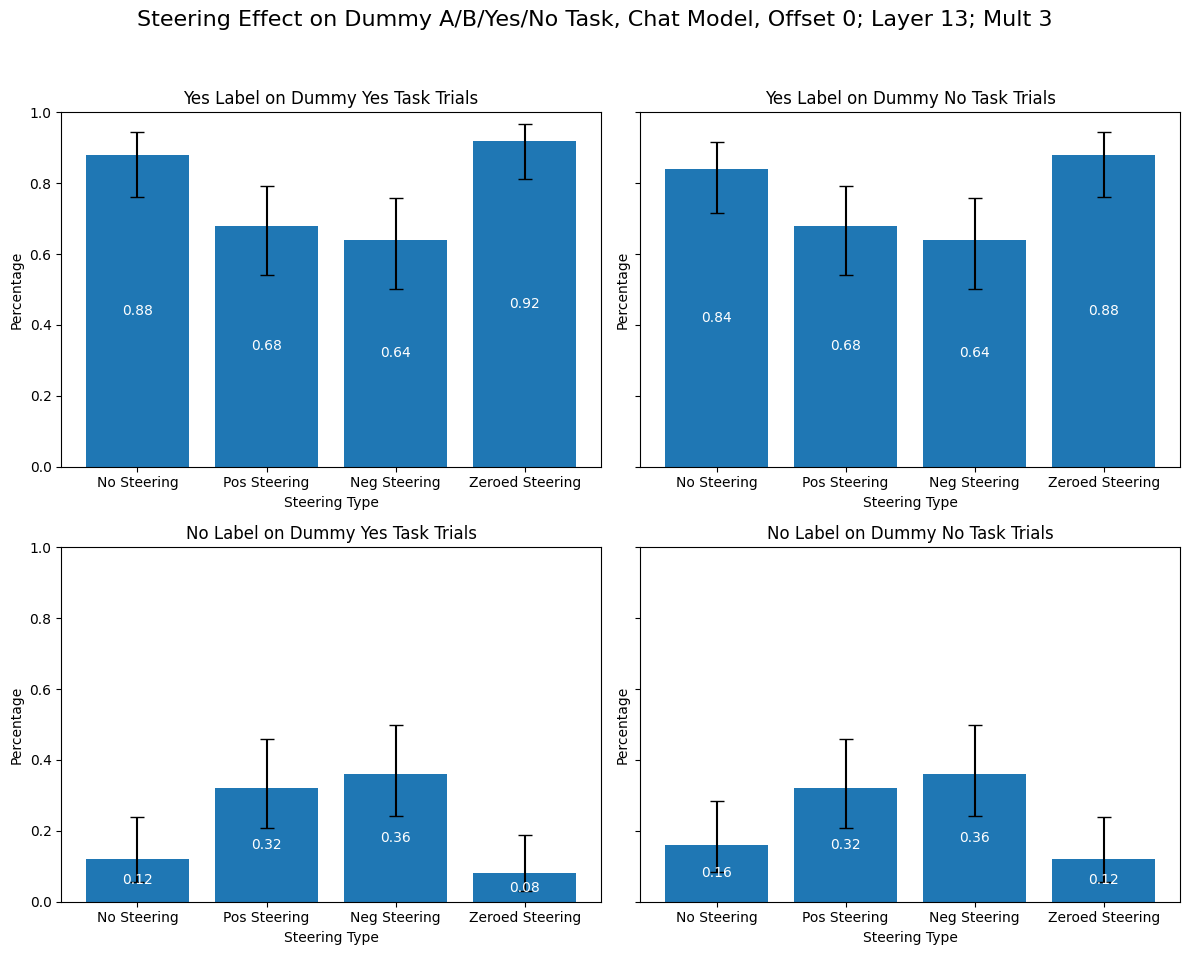

In [7]:
pos_label_name = "Yes"#"Self"# 
neg_label_name = "No"#"Other"#
pos_trial_name = "Dummy Yes Task"#"Self Written"# (Reversed)"#
neg_trial_name = "Dummy No Task"#"Other Written"# (Reversed)"#

from statsmodels.stats.proportion import proportion_confint
data = {
    f"{pos_label_name} Label on {pos_trial_name} Trials": [
        nosteering_pos_label_on_pos_trials / truectr,
        possteering_pos_label_on_pos_trials / truectr,
        negsteering_pos_label_on_pos_trials / truectr,
        zerosteering_pos_label_on_pos_trials / truectr
    ],
    f"{pos_label_name} Label on {neg_trial_name} Trials": [
        nosteering_pos_label_on_neg_trials / falsectr,
        possteering_pos_label_on_neg_trials / falsectr,
        negsteering_pos_label_on_neg_trials / falsectr,
        zerosteering_pos_label_on_neg_trials / falsectr
    ],
    f"{neg_label_name} Label on {pos_trial_name} Trials": [
        nosteering_neg_label_on_pos_trials / truectr,
        possteering_neg_label_on_pos_trials / truectr,
        negsteering_neg_label_on_pos_trials / truectr,
        zerosteering_neg_label_on_pos_trials / truectr
    ],
    f"{neg_label_name} Label on {neg_trial_name} Trials": [
        nosteering_neg_label_on_neg_trials / falsectr,
        possteering_neg_label_on_neg_trials / falsectr,
        negsteering_neg_label_on_neg_trials / falsectr,
        zerosteering_neg_label_on_neg_trials / falsectr
    ]
}

# Calculate confidence intervals
confidence_intervals = {
    f"{pos_label_name} Label on {pos_trial_name} Trials": [
        proportion_confint(nosteering_pos_label_on_pos_trials, truectr, method='wilson'),
        proportion_confint(possteering_pos_label_on_pos_trials, truectr, method='wilson'),
        proportion_confint(negsteering_pos_label_on_pos_trials, truectr, method='wilson'),
        proportion_confint(zerosteering_pos_label_on_pos_trials, truectr, method='wilson')
    ],
    f"{pos_label_name} Label on {neg_trial_name} Trials": [
        proportion_confint(nosteering_pos_label_on_neg_trials, falsectr, method='wilson'),
        proportion_confint(possteering_pos_label_on_neg_trials, falsectr, method='wilson'),
        proportion_confint(negsteering_pos_label_on_neg_trials, falsectr, method='wilson'),
        proportion_confint(zerosteering_pos_label_on_neg_trials, falsectr, method='wilson')
    ],
    f"{neg_label_name} Label on {pos_trial_name} Trials": [
        proportion_confint(nosteering_neg_label_on_pos_trials, truectr, method='wilson'),
        proportion_confint(possteering_neg_label_on_pos_trials, truectr, method='wilson'),
        proportion_confint(negsteering_neg_label_on_pos_trials, truectr, method='wilson'),
        proportion_confint(zerosteering_neg_label_on_pos_trials, truectr, method='wilson')
    ],
    f"{neg_label_name} Label on {neg_trial_name} Trials": [
        proportion_confint(nosteering_neg_label_on_neg_trials, falsectr, method='wilson'),
        proportion_confint(possteering_neg_label_on_neg_trials, falsectr, method='wilson'),
        proportion_confint(negsteering_neg_label_on_neg_trials, falsectr, method='wilson'),
        proportion_confint(zerosteering_neg_label_on_neg_trials, falsectr, method='wilson')
    ]
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.suptitle('Steering Effect on Dummy A/B/Yes/No Task, Chat Model, Offset 0; Layer 13; Mult 3', fontsize=16)

steering_types = ["No Steering", "Pos Steering", "Neg Steering", "Zeroed Steering"]

for ax, (title, values) in zip(axes.flatten(), data.items()):
    ci = confidence_intervals[title]
    lower_bounds = [ci[i][0] for i in range(4)]
    upper_bounds = [ci[i][1] for i in range(4)]
    yerr = [values[i] - lower_bounds[i] for i in range(4)], [upper_bounds[i] - values[i] for i in range(4)]
    
    bars = ax.bar(steering_types, values, yerr=yerr, capsize=5)

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position: middle of the bar
            height / 2,  # Y position: middle of the bar (half of the bar's height)
            f'{height:.2f}',  # The text to display
            ha='center',  # Center horizontally
            va='center',  # Center vertically
            color='white'  # Color of the text
        )

    ax.set_title(title)
    ax.set_ylim(0, 1)  # Assuming percentages between 0 and 1
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Steering Type')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [379]:
stats.ttest_rel(np.array([neut_colorself_probs[i] for i in range(len(neut_colorself_probs)) if i%2==0]), np.array(zeroed_colorself_probs))

TtestResult(statistic=4.658149507557842, pvalue=7.081929519701056e-06, df=147)

/Users/christopherackerman/repos/spar_self_recognition/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


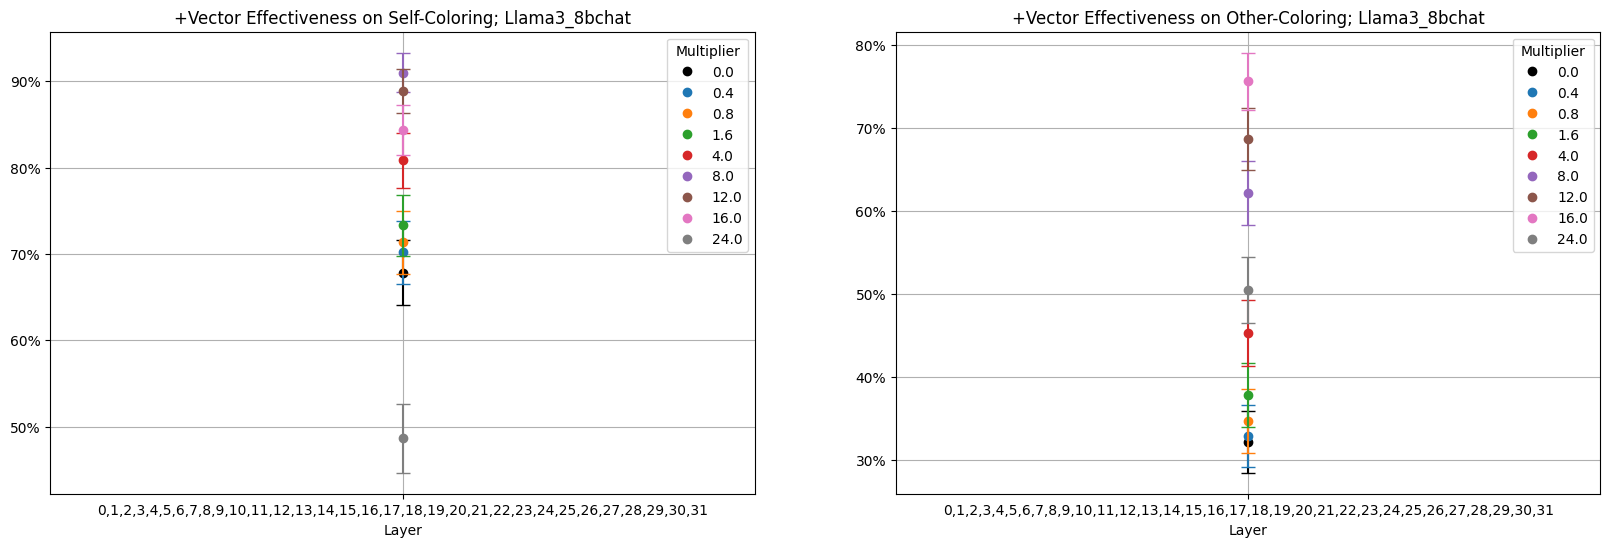

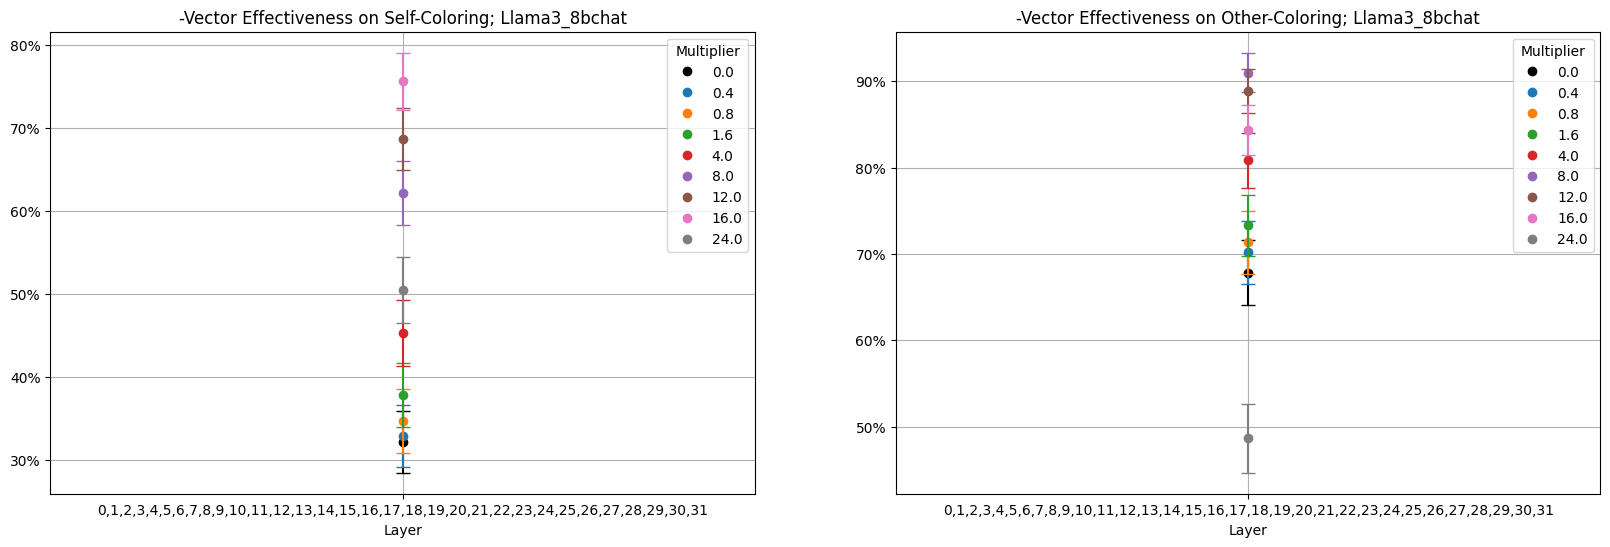

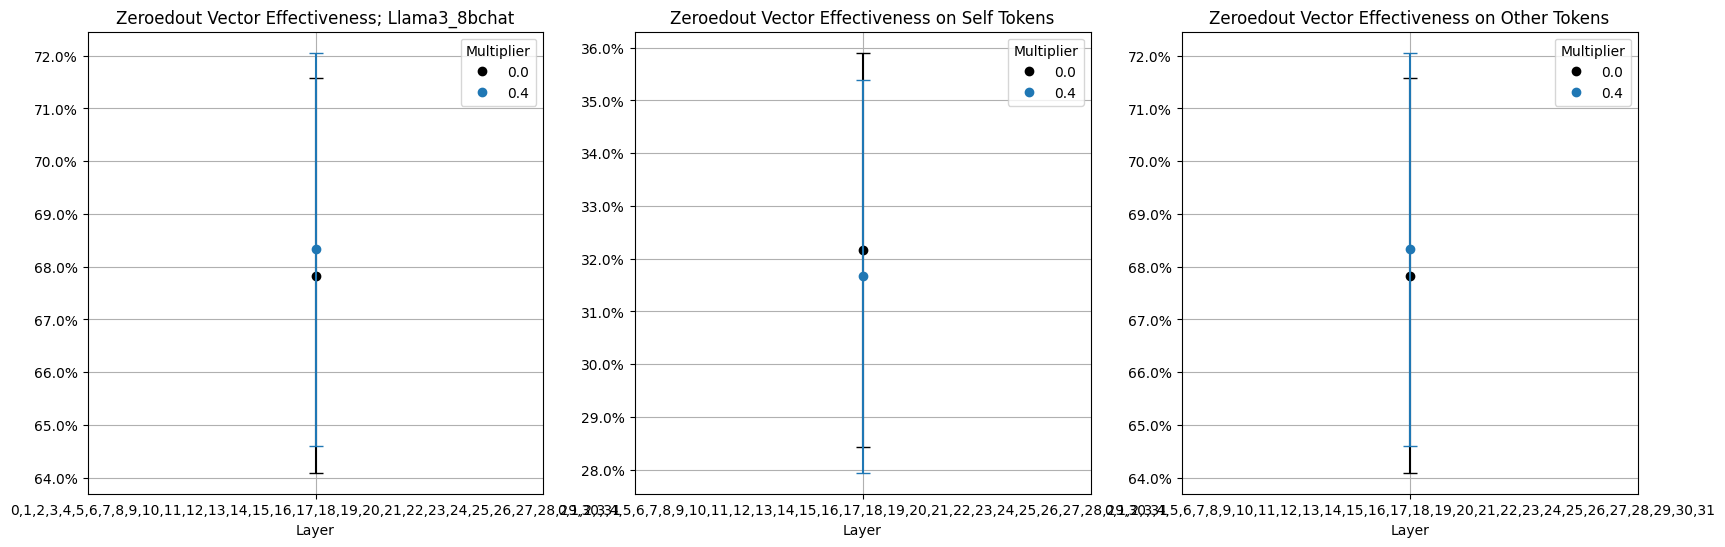

In [885]:
### Assess steering effectiveness
### Paired presentation
### Compute Accuracy%, CIs, and plot

model_name = "llama3_8bchat"
outputdir="./steering_output/"

file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad.json"
file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad_colortext.json"
#file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad_colortext2.json"
file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad_colortext3.json"
file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad_colortext_onedir.json"
file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad2_colortext_bothdir.json"
#file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_cnn_colortext_bothdir.json"
#file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_dolly_colortext_bothdir.json"
file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_qa_colortext_bothdir.json"
#file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_xsum_colortext_bothdir.json"

with open(file, 'r') as infile:
    resps = json.load(infile)

layer_mult_combinations = get_sorted_layer_mult_combinations(resps)

#get unique layers and mults from the keys
layers = list({key.split('_')[0][5:]: None for key in layer_mult_combinations}.keys())
mults = list(sorted(set(float(key.split('_')[1][4:]) for key in layer_mult_combinations)))

#set up dfs to hold results
pos_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
neg_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
pos_effectiveness_colorself_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
neg_effectiveness_colorself_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
pos_effectiveness_colorother_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
control_effectiveness_colorother_df = pd.DataFrame(0.0, index=layers, columns=mults)
neg_effectiveness_colorother_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)

zeroedout_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_effectiveness_colorself_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_effectiveness_colorother_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)

for layermult in layer_mult_combinations:
    layer = layermult.split('_')[0][5:]
    mult = float(layermult.split('_')[1][4:])
    #print(f"Layer {layer}, Mult {mult}")

    sentctr=0
    colorselfctr, colorotherctr = 0, 0
    if mult == 4: pos_colorself_probs, pos_colorother_probs, neg_colorself_probs, neg_colorother_probs, zeroed_colorself_probs, zeroed_colorother_probs, neut_colorself_probs, neut_colorother_probs = [], [], [], [], [], [], [], []
    for i, entry in enumerate(resps):
        #true_label = 1 if entry['sentence']['model'] == model_name else -1
        self_label, other_label = ("1", "2")  if ((i//2) % 2) == 0 else ("2", "1")
        colorself = True if (i % 4 == 0) or (i % 4 == 3) else False
        colorother = not colorself
        if colorself: colorselfctr += 1
        else: colorotherctr += 1
        if mult == 4 and "bothdir" in file:
            if colorself: 
                pos_colorself_probs.append(entry['steered'][layermult]['prob_targ_pos'])
                neg_colorself_probs.append(entry['steered'][layermult]['prob_targ_neg'])
                if i%2==0: zeroed_colorself_probs.append(entry['steered'][layermult]['prob_targ_zeroedout'])
                neut_colorself_probs.append(entry['prob_targ_neut'])
            else: 
                pos_colorother_probs.append(entry['steered'][layermult]['prob_targ_pos'])
                neg_colorother_probs.append(entry['steered'][layermult]['prob_targ_neg'])
                if i%2==0: zeroed_colorother_probs.append(entry['steered'][layermult]['prob_targ_zeroedout'])
                neut_colorother_probs.append(entry['prob_targ_neut'])
        if (entry['steered'][layermult]['answer_pos'] == self_label) and colorself: 
            pos_effectiveness_colorself_df.loc[layer, mult] += 1
        if (entry['steered'][layermult]['answer_pos'] == other_label) and colorother: 
            pos_effectiveness_colorother_df.loc[layer, mult] += 1
        if entry['steered'][layermult]['answer_neg'] == self_label and colorother: 
            neg_effectiveness_colorother_df.loc[layer, mult] += 1
        if entry['steered'][layermult]['answer_neg'] == other_label and colorself: 
            neg_effectiveness_colorself_df.loc[layer, mult] += 1
        if entry['answer_neut'] == self_label: 
            if i%2==0 or "bothdir" not in file: zeroedout_effectiveness_df.loc[layer, 0] += 1/len(mults)
            if colorself: 
                pos_effectiveness_colorself_df.loc[layer, 0] += 1/len(mults)
            else: 
                neg_effectiveness_colorother_df.loc[layer, 0] += 1/len(mults)
                zeroedout_effectiveness_colorother_df.loc[layer, 0] += 1/len(mults)
        if entry['answer_neut'] == other_label: 
            if colorself:
                neg_effectiveness_colorself_df.loc[layer, 0] += 1/len(mults)
                zeroedout_effectiveness_colorself_df.loc[layer, 0] += 1/len(mults)
            else:
                pos_effectiveness_colorother_df.loc[layer, 0] += 1/len(mults)
        if entry['steered'][layermult]['answer_zeroedout'] == self_label: 
            if i%2==0 or "bothdir" not in file: zeroedout_effectiveness_df.loc[layer, mult] += 1
            if colorother: zeroedout_effectiveness_colorother_df.loc[layer, mult] += 1
        elif entry['steered'][layermult]['answer_zeroedout'] == other_label: 
            if colorself: zeroedout_effectiveness_colorself_df.loc[layer, mult] += 1
        sentctr += 1

#fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
#plot_effectiveness(axs[0], pos_effectiveness_df, sentctr, f"+Vector Effectiveness; {model_name.capitalize()}")
#plot_effectiveness(axs[1], neg_effectiveness_df, sentctr, f"-Vector Effectiveness; {model_name.capitalize()}")
#plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
plot_effectiveness(axs[0], pos_effectiveness_colorself_df, colorselfctr, f"+Vector Effectiveness on Self-Coloring; {model_name.capitalize()}")
plot_effectiveness(axs[1], pos_effectiveness_colorother_df, colorotherctr, f"+Vector Effectiveness on Other-Coloring; {model_name.capitalize()}")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
plot_effectiveness(axs[0], neg_effectiveness_colorself_df, colorselfctr, f"-Vector Effectiveness on Self-Coloring; {model_name.capitalize()}")
plot_effectiveness(axs[1], neg_effectiveness_colorother_df, colorotherctr, f"-Vector Effectiveness on Other-Coloring; {model_name.capitalize()}")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
plot_effectiveness(axs[0], zeroedout_effectiveness_df.iloc[:, :2], sentctr//2 if "bothdir" in file else sentctr, f"Zeroedout Vector Effectiveness; {model_name.capitalize()}")
plot_effectiveness(axs[1], zeroedout_effectiveness_colorself_df.iloc[:, :2], colorselfctr, f"Zeroedout Vector Effectiveness on Self Tokens")
plot_effectiveness(axs[2], zeroedout_effectiveness_colorother_df.iloc[:, :2], colorotherctr, f"Zeroedout Vector Effectiveness on Other Tokens")
plt.show()


In [403]:
zeroedout_effectiveness_df/(sentctr//2)

,0.000,0.175,0.200,0.225,0.250,0.275,0.300,0.350,0.400,0.800,1.600,4.000,30.000,100.000
"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31",0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486,0.611486


In [440]:
#loop over every entry in resps, and compare answer_neut with answer_zeroedout at layermult 
b1=b2=n1z2=n2z1=0
bs=bo=nszo=nozs=0
for i,entry in enumerate(resps):
    if i%2: continue
    self_token="1" if (i//2)%2==0 else "2"
    other_token = "2" if self_token=="1" else "1"
    if entry['answer_neut'] == entry['steered']["layer0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31_mult0.4"]['answer_zeroedout']:
        if entry['answer_neut'] == "1": b1 += 1
        elif entry['answer_neut'] == "2": b2 += 1
        if entry['answer_neut'] == self_token: bs += 1
        elif entry['answer_neut'] == other_token: bo += 1
    else:
        if entry['answer_neut'] == "1": n1z2 += 1
        elif entry['answer_neut'] == "2": n2z1 += 1
        if entry['answer_neut'] == self_token: nszo += 1
        elif entry['answer_neut'] == other_token: nozs += 1
#b1, b2, n1z2, n2z1
bs, bo, nszo, nozs

(42, 14, 1, 5)

In [863]:
file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_qa_colortext_bothdir.json"
#file = f"{outputdir}paired_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad2_colortext_bothdir.json"
#file = f"{outputdir}individual_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_sad_colortext.json"
#file = f"{outputdir}individual_steering_selfrecnew3_projectoutnuisance_meandiff_offset1_coronly_qa_colortext4.json"
with open(file, 'r') as infile:
    resps = json.load(infile)
orig_self_prob_higher=zeroed_self_prob_higher=0
for i,entry in enumerate(resps):
    if "bothdir" in file and i%4!=0 and i%4!=3: continue
    dif = abs(entry['prob_neut']-.5) - abs(entry['steered']["layer0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31_mult16"]['prob_zeroedout']-.5)
    if dif>0:
        orig_self_prob_higher += 1
    elif dif<0:
        zeroed_self_prob_higher += 1
orig_self_prob_higher, zeroed_self_prob_higher

(326, 273)

In [311]:
#set column width   
pd.set_option('display.max_columns', None)
#set overallwidth
pd.set_option('display.width', 1000)
pos_effectiveness_colorself_df,pos_effectiveness_colorother_df

(                                                    0.000    0.175    0.200    0.225    0.250    0.275    0.300    0.350    0.400    0.800    1.600    4.000    30.000   100.000
 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,...     70.0     73.0     77.0     74.0     79.0     73.0     76.0     79.0     74.0     78.0     83.0     86.0     32.0      0.0,
                                                     0.000    0.175    0.200    0.225    0.250    0.275    0.300    0.350    0.400    0.800    1.600    4.000    30.000   100.000
 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,...     31.0     32.0     31.0     28.0     26.0     32.0     31.0     30.0     32.0     30.0     41.0     51.0     44.0      0.0)

In [684]:
import numpy as np
from scipy import stats

def analyze_steering_effect_paired(results, direction, steering_condition):
    steered_diffs = []

    for i, entry in enumerate(results):
        if "bothdir" in file and (i % 2) and ("zeroedout" in direction): continue #zeroing out both texts, so odd and even inputs are the same
        # Extract the original probability
        base = "prob_targ_neut" if "targ" in direction else "prob_neut"
        prob_neut = entry.get(base)
        if prob_neut is None:
            print("missing prob_neut")
            continue  # Skip if original probability is missing

        # Extract the steered probability
        steered = entry.get("steered", {})
        # Analyze a specific steering condition
        steered_entry = steered.get(steering_condition, {})
        steered_prob = steered_entry.get(direction)
        if steered_prob is None:
            print("missing steered_prob")
            continue  # Skip if steered probability is missing

        # Compute the difference between original and steered probabilities
        if "targ" not in direction and "zeroedout" not in direction: #zeroing out both texts should lead towards chance performance on targeted token; ie, decreased performance on the self token
            if (i % 4 == 0) or (i % 4 == 3):
                steered_diffs.append(steered_prob - prob_neut)
            else:
                steered_diffs.append(prob_neut - steered_prob)
        else:
            steered_diffs.append(steered_prob - prob_neut)

    steered_diffs = np.array(steered_diffs)

    # Perform t-test vs. zero mean
    t_stat, p_value = stats.ttest_1samp(steered_diffs, 0)

    # Calculate mean difference
    mean_diff = np.mean(steered_diffs)

    # Prepare the results
    test_results = {
        "t_statistic": t_stat,
        "p_value": p_value,
        "mean_difference": mean_diff,
        "num_samples": len(steered_diffs)
    }

    return test_results, steered_diffs


test_results, steered_diffs = analyze_steering_effect_paired(resps, "prob_zeroedout", steering_condition="layer0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31_mult16")

print("Statistical Test Results:")
print(f"Number of samples: {test_results['num_samples']}")
print(f"Mean difference: {test_results['mean_difference']}")
print(f"T-statistic: {test_results['t_statistic']}")
print(f"P-value: {test_results['p_value']}")

# Bootstrap resampling
n_bootstrap = 10000
bootstrap_deltas = np.zeros(n_bootstrap)

n = len(steered_diffs)
#np.random.seed(42)

for i in range(n_bootstrap):
    sample_steered = np.random.choice(steered_diffs, size=n, replace=True)
    bootstrap_deltas[i] = np.mean(sample_steered)

alpha = 0.01
lower = np.percentile(bootstrap_deltas, alpha/2*100)
upper = np.percentile(bootstrap_deltas, (1 - alpha/2)*100)
print(f"99% confidence interval: [{lower}, {upper}]")


Statistical Test Results:
Number of samples: 198
Mean difference: -0.0028844062148386408
T-statistic: -0.5413158156140767
P-value: 0.5889015467205128
99% confidence interval: [-0.016584298164213918, 0.010337585883151396]


(array([ 1.,  1.,  0.,  0.,  1.,  2.,  1.,  1.,  4.,  3.,  5.,  5.,  5.,
         4.,  2.,  6.,  7.,  9., 18., 10.,  7.,  8.,  9.,  4.,  6.,  5.,
         5.,  5.,  4.,  9.,  3.,  2.,  2.,  4.,  3.,  1.,  0.,  1.,  0.,
         1.,  0.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.22266027, -0.21038439, -0.19810852, -0.18583264, -0.17355676,
        -0.16128088, -0.149005  , -0.13672912, -0.12445324, -0.11217736,
        -0.09990149, -0.08762561, -0.07534973, -0.06307385, -0.05079797,
        -0.03852209, -0.02624621, -0.01397033, -0.00169446,  0.01058142,
         0.0228573 ,  0.03513318,  0.04740906,  0.05968494,  0.07196082,
         0.0842367 ,  0.09651258,  0.10878845,  0.12106433,  0.13334021,
         0.14561609,  0.15789197,  0.17016785,  0.18244373,  0.19471961,
         0.20699548,  0.21927136,  0.23154724,  0.24382312,  0.256099  ,
         0.26837488,  0.28065076,  0.29292664,  0.30520251,  0.31747839,
         0.32975427,  0.34203015,  0.35430603,  0.36658191,

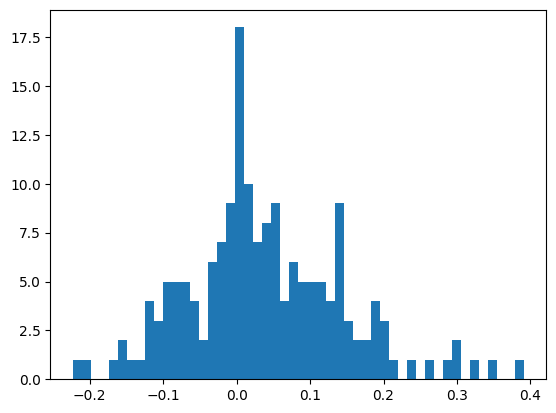

In [675]:
plt.hist(steered_diffs, bins=50)

In [820]:
pos_effectiveness_colorother_df

,0.0,0.4,0.8,1.6,4.0,8.0,12.0,16.0,24.0
"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31",193.0,197.0,208.0,227.0,272.0,373.0,412.0,454.0,303.0


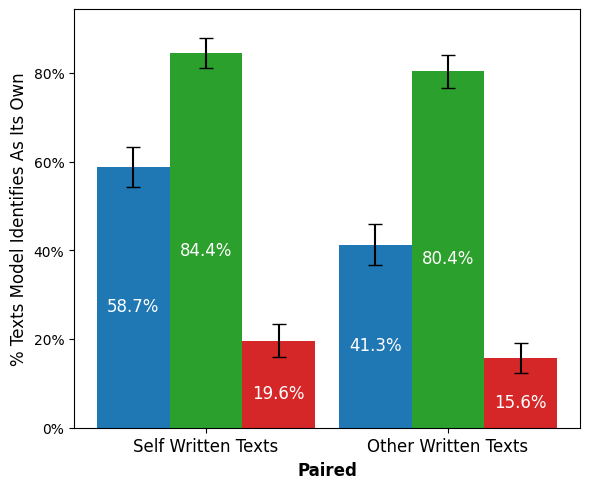

In [884]:
import matplotlib.pyplot as plt
import numpy as np

n = sentctr / 2 

data = [(df.iloc[0][df.columns[0]], df.iloc[0][16]) for df in [
    pos_effectiveness_colorself_df,
    neg_effectiveness_colorself_df,
    pos_effectiveness_colorother_df,
    neg_effectiveness_colorother_df
]]

# Calculate proportions
y_orig = [data[0][0]/n, data[2][0]/n]  # Original rates for self and other
y_steered_pos = [data[0][1]/n, data[2][1]/n]  # Positive steering for self and other
y_steered_neg = [1-data[1][1]/n, 1-data[3][1]/n]  # Negative steering for self and other

# Error calculation for 95% confidence intervals
error_orig = [1.96 * np.sqrt((p * (1-p)) / n) for p in y_orig]
error_steered_pos = [1.96 * np.sqrt((p * (1-p)) / n) for p in y_steered_pos]
error_steered_neg = [1.96 * np.sqrt((p * (1-p)) / n) for p in y_steered_neg]

plt.figure(figsize=(6, 5))
x = np.array([0, 0.5])  # Reduced space between sets of bars

bar_width = 0.15
x_orig = x - bar_width  # For unsteered
x_pos = x              # For positive steering
x_neg = x + bar_width  # For negative steering

# Color choices
colors = ['#1f77b4', '#2ca02c', '#d62728']

# Plotting bars
bars_orig = plt.bar(x_orig, y_orig, width=bar_width, color=colors[0], label='Unsteered', yerr=error_orig, capsize=5)
bars_pos = plt.bar(x_pos, y_steered_pos, width=bar_width, color=colors[1], label='Positive Steering', yerr=error_steered_pos, capsize=5)
bars_neg = plt.bar(x_neg, y_steered_neg, width=bar_width, color=colors[2], label='Negative Steering', yerr=error_steered_neg, capsize=5)

# Adding text inside bars (now as percentages)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, max(0.02, height - height/2), f'{height:.1%}', ha='center', va='top', color='white', fontsize=12)

add_labels(bars_orig)
add_labels(bars_pos)
add_labels(bars_neg)

plt.xlabel('Paired', fontsize=12, fontweight='bold')
plt.ylabel('% Texts Model Identifies As Its Own', fontsize=12)
#plt.title('Text Coloring Effects by Steering and Text Type', fontsize=16)
plt.xticks(x, ['Self Written Texts', 'Other Written Texts'], fontsize=12)
plt.ylim(0, max(max(y_orig + error_orig), max(y_steered_pos + error_steered_pos), max(y_steered_neg + error_steered_neg)) + 0.1)  # Adjust y-axis limit

# Set y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f"./figs_new/coloring_paired_qa.png")
plt.show()
